In [14]:

!pip install kaggle pycocotools matplotlib pillow tqdm --quiet

import os, zipfile, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO


from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


DATASET = "awsaf49/coco-2017-dataset"
SAVE_DIR = "dataset"
ZIP_PATH = os.path.join(SAVE_DIR, "coco-2017-dataset.zip")
os.makedirs(SAVE_DIR, exist_ok=True)


!mkdir -p train2017 val2017 annotations


!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -qq annotations_trainval2017.zip -d annotations


!wget -q http://images.cocodataset.org/zips/val2017.zip
!unzip -qq val2017.zip -d val2017


!wget -q http://images.cocodataset.org/zips/train2017.zip
!mkdir -p train_subset
!unzip -qq train2017.zip "train2017/00*.jpg" "train2017/01*.jpg" "train2017/02*.jpg" -d train_subset


print("✅ Extracted ~20 000 COCO images + annotations successfully!")



Saving kaggle.json to kaggle.json
caution: filename not matched:  train2017/01*.jpg
caution: filename not matched:  train2017/02*.jpg
✅ Extracted ~20 000 COCO images + annotations successfully!


In [ ]:


!pip install albumentations opencv-python tqdm --quiet

import cv2
import numpy as np
import os
from tqdm import tqdm
import albumentations as A
from pycocotools.coco import COCO
from PIL import Image

# --- Step 1: Paths ---
ANNOTATION_FILE = "/content/annotations/annotations/instances_val2017.json"
IMAGE_DIR = "/content/val2017/val2017"
OUTPUT_IMG_DIR = "processed/images"
OUTPUT_MASK_DIR = "processed/masks"
os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

# --- Step 2: Initialize COCO ---
coco = COCO(ANNOTATION_FILE)
img_ids = coco.getImgIds()

# --- Step 3: Define preprocessing pipeline ---
IMAGE_SIZE = 256

preprocess = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
])

# --- Step 4: Define augmentation pipeline ---
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                       rotate_limit=15, p=0.5),
])

# --- Step 5: Process and align ---
print("🔹 Starting preprocessing and augmentation...")

for img_id in tqdm(img_ids[:200]):  # limit to first 200 for testing
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(IMAGE_DIR, img_info["file_name"])
    if not os.path.exists(img_path):
        continue

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load and combine masks
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    # Apply augmentation
    augmented = augment(image=img, mask=mask)
    img_aug, mask_aug = augmented["image"], augmented["mask"]

    # Apply preprocessing
    processed = preprocess(image=img_aug, mask=mask_aug)
    img_prep, mask_prep = processed["image"], processed["mask"]

    # Save outputs (keep same name)
    out_name = os.path.splitext(img_info["file_name"])[0]
    cv2.imwrite(f"{OUTPUT_IMG_DIR}/{out_name}.jpg", cv2.cvtColor((img_prep * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(f"{OUTPUT_MASK_DIR}/{out_name}.png", (mask_prep * 255).astype(np.uint8))

print("✅ Preprocessing completed successfully!")
print(f"📁 Saved processed images to: {OUTPUT_IMG_DIR}")
print(f"📁 Saved processed masks to: {OUTPUT_MASK_DIR}")


loading annotations into memory...


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Done (t=0.90s)
creating index...
index created!
🔹 Starting preprocessing and augmentation...


100%|██████████| 200/200 [00:03<00:00, 50.39it/s]

✅ Preprocessing completed successfully!
📁 Saved processed images to: processed/images
📁 Saved processed masks to: processed/masks


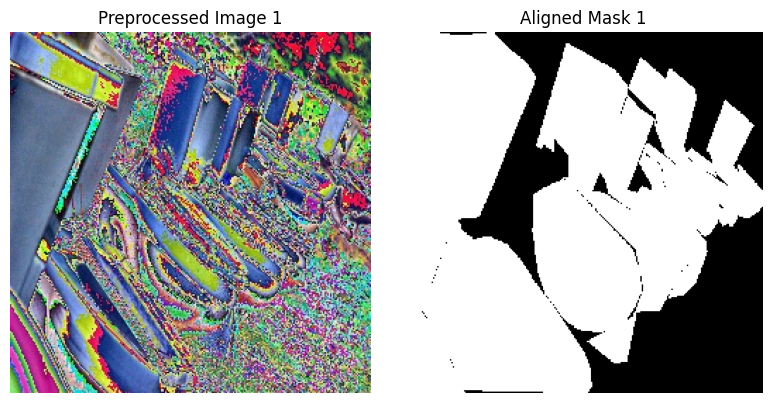

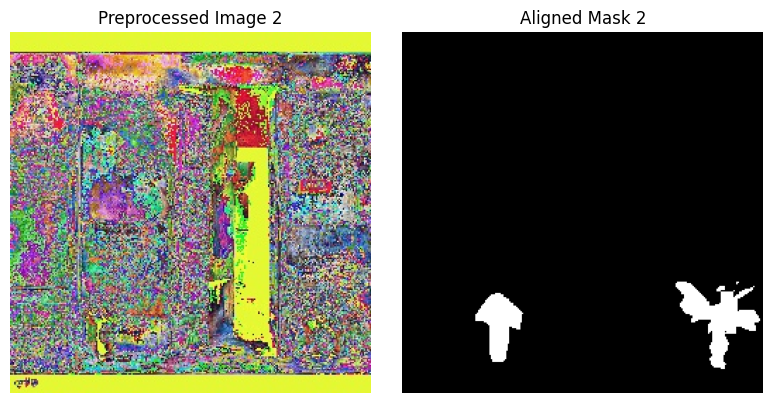

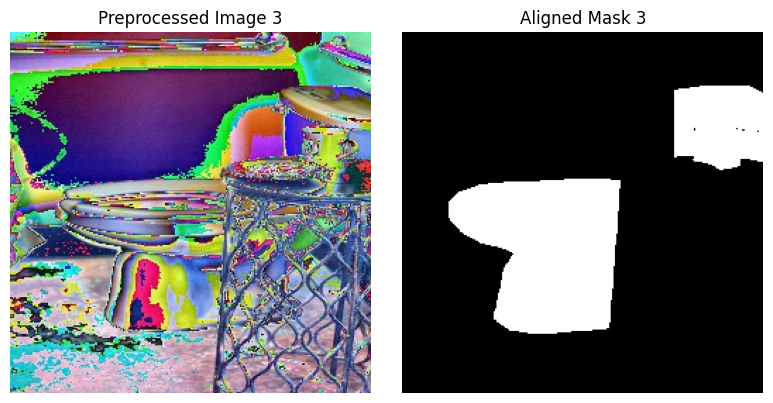

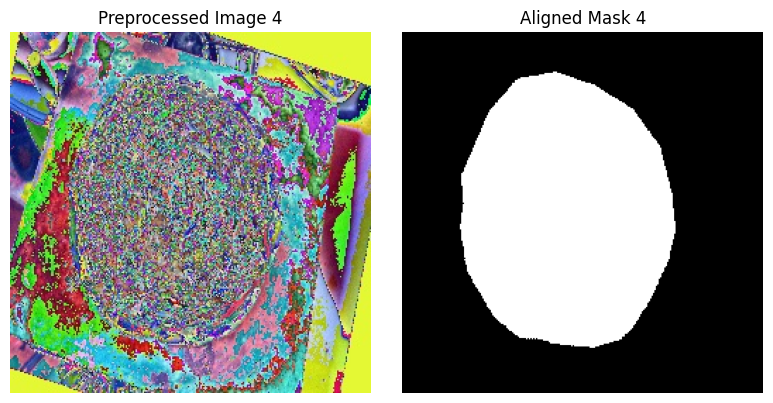

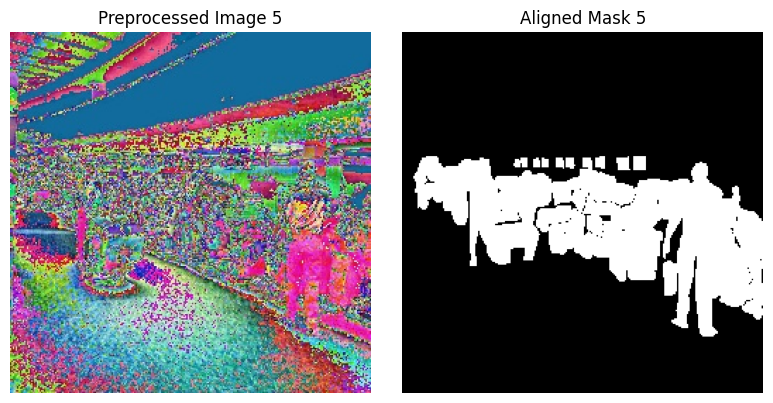

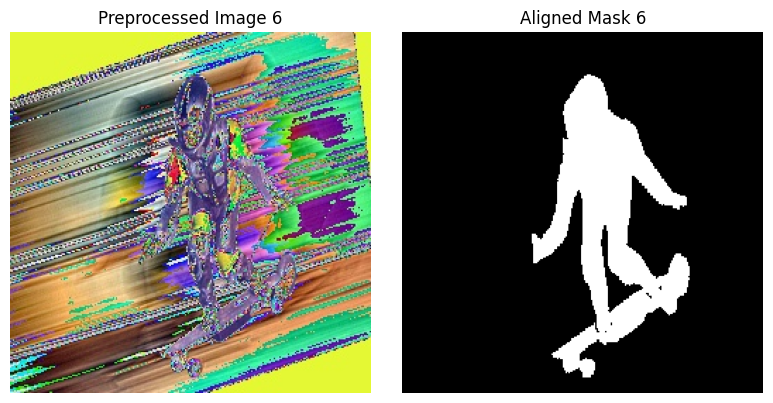

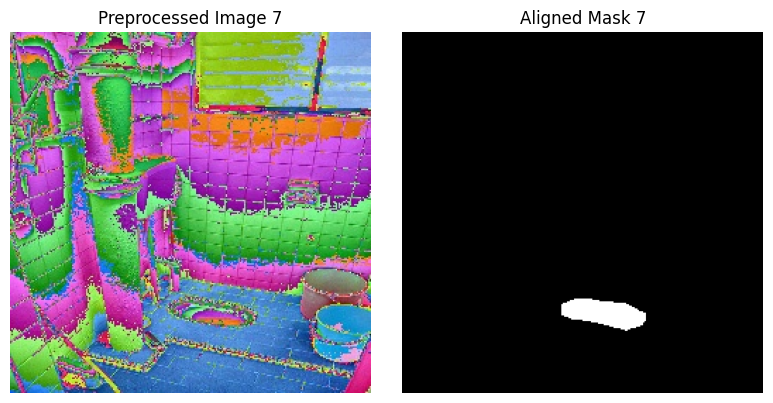

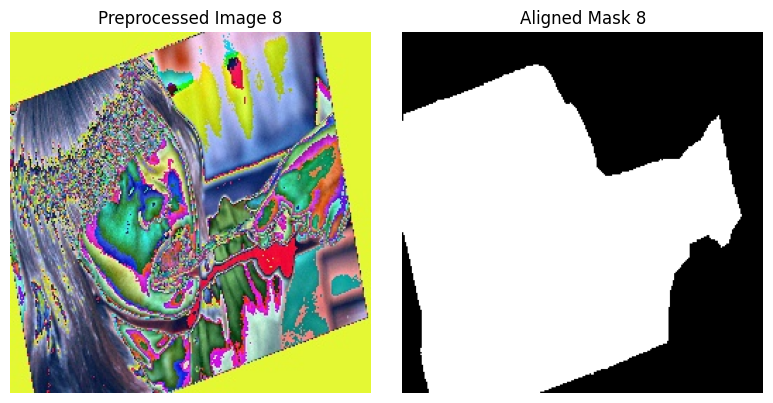

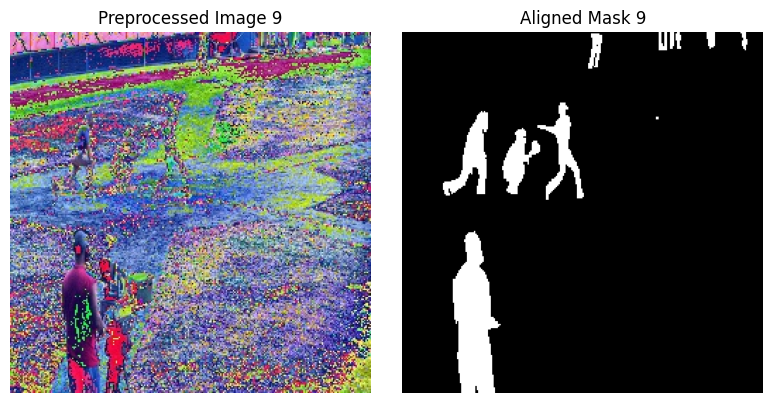

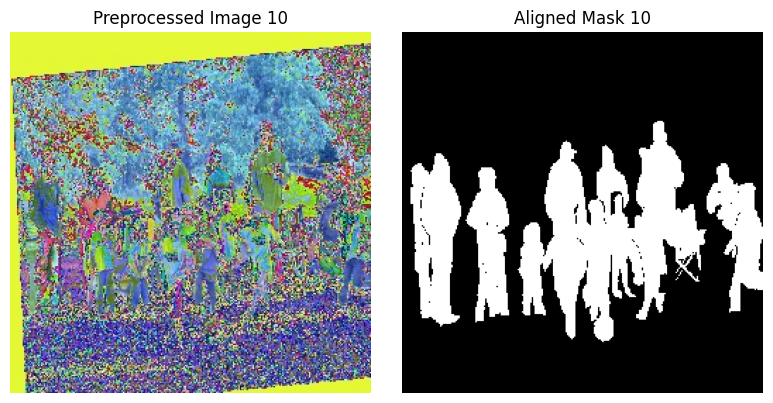

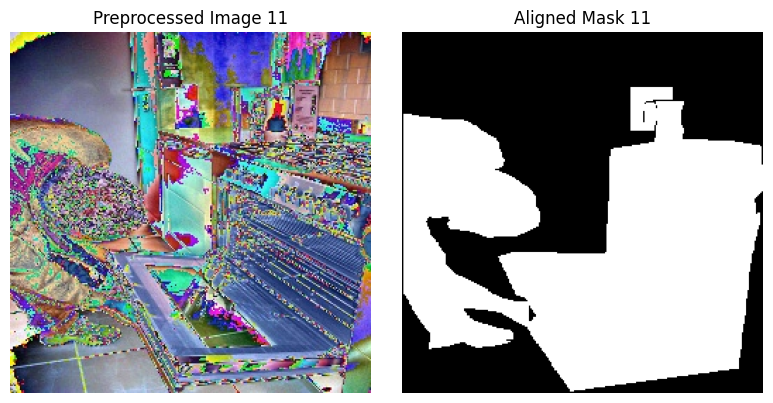

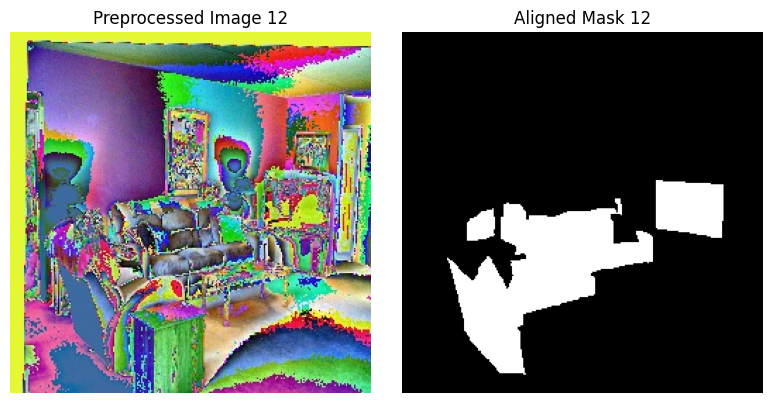

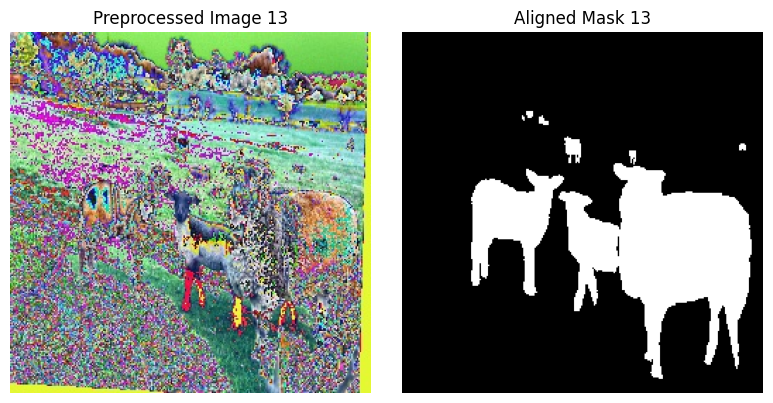

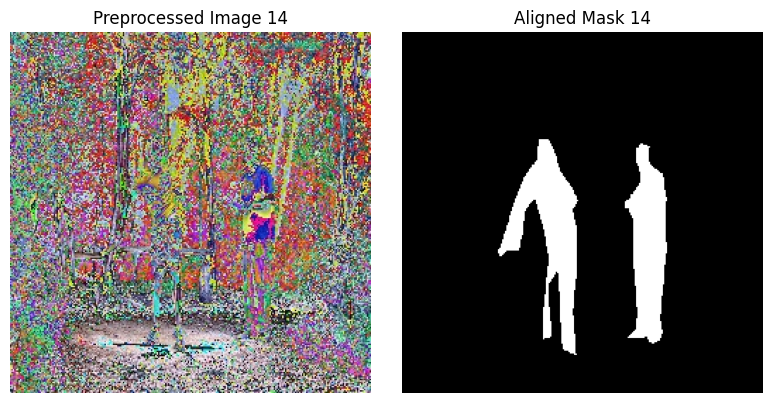

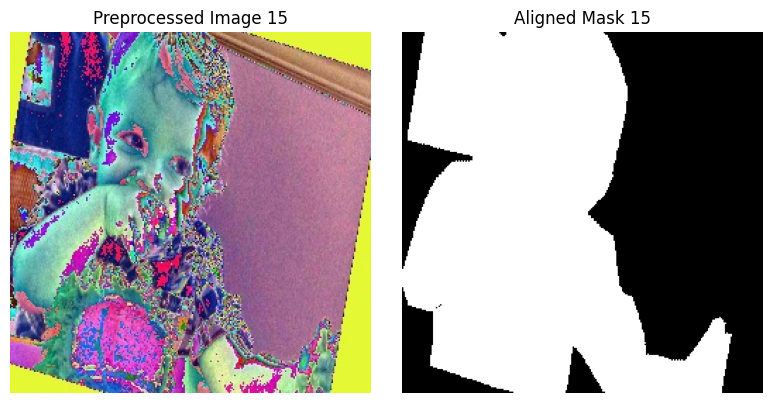

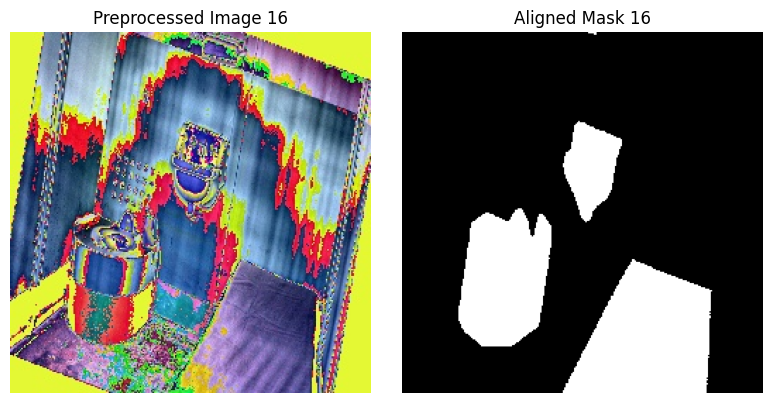

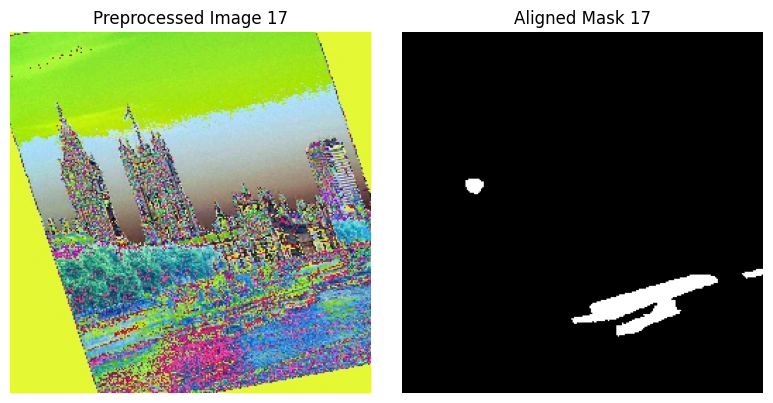

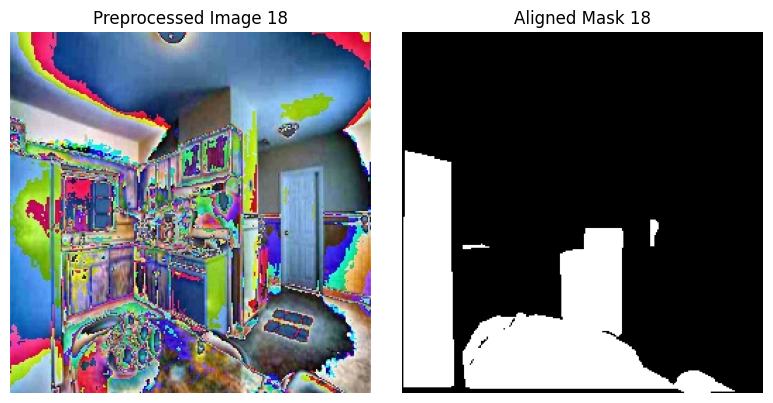

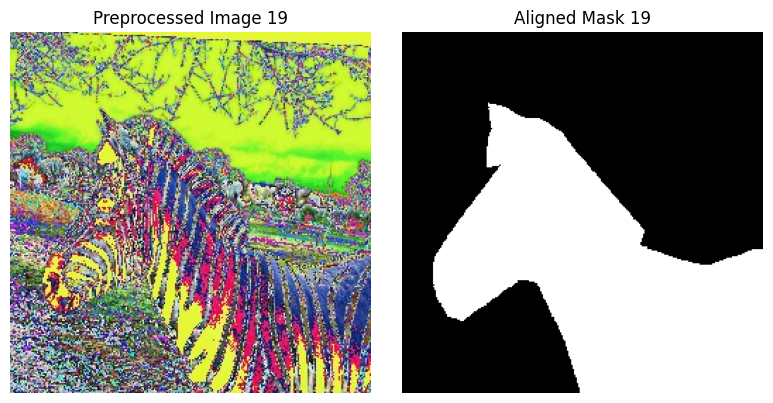

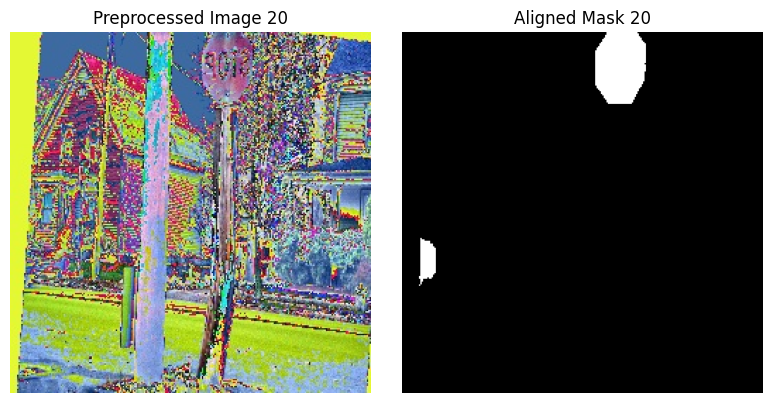

In [23]:
# ============================================================
# 🎯 Data Preprocessing & Validation Visualization (20 Samples)
# ============================================================

import random
import matplotlib.pyplot as plt
import cv2
import os

# Paths to preprocessed folders
IMG_DIR = "processed/images"
MASK_DIR = "processed/masks"

# Pick 20 random samples
samples = random.sample(os.listdir(IMG_DIR), 20)

# Display
for i, fname in enumerate(samples, 1):
    img_path = os.path.join(IMG_DIR, fname)
    mask_path = os.path.join(MASK_DIR, fname.replace(".jpg", ".png"))

    if not os.path.exists(mask_path):
        continue

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img)
    ax[0].set_title(f"Preprocessed Image {i}")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title(f"Aligned Mask {i}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()
